In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Introduction


<a id="section-one"></a>
# Import packages

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
!pip install statsmodels
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata



<a id="section-two"></a>
# Get weekly sentiment for stock ticker

There is much more to the process of stock price formation than plain historical data. Over 1 day, one online post might be a turning point in the course of events, which may result in the market crash. Elon Musk tweets, coronavirus, start of russian full-scale invasion of Ukraine are the proof to that. Therefore, we will take into account another important external indicator, such as the mood of stock market participants. The most effective method in this task is the analysis of the tone (sentiment analysis) of the text, in this notewook we will be consider posts in the social network Twitter.

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import re
import contractions
# Define the preprocessing steps
def preprocess_text (text) :

  text = text.lower()

  text = re.sub(r'https?:\/V.*[\r\n]*',' ', text)
  text = re.sub(r'www.*[\r\n]*','', text)
  text = re.sub(r'https', ' ', text)
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

  text = re. sub(r'\@\w+','',text)
  text = re.sub(r'\#\w+', '', text)
  text = re.sub(r'@[a-z0-9]+', '', text)
  text = re.sub(r'#[a-z0-9]', '', text)
  text = re.sub(r'@', '', text)
  text = re.sub(r'#', '', text)

  text = text.encode('ascii', 'ignore').decode('ascii')

  text = contractions.fix(text)

  text = text. replace('%', ' percent')
  text = re. sub(r'&amp',
  'and ', text)
  text = re.sub(r'&gt', ' greater than ', text)

  text = re. sub(r'p&f', 'point and figure', text)
  text = re. sub(r's&p', 'SP500', text)
  text = re. sub(r'q&a', 'question and answer', text)
  text = re.sub(r'b/c', ' because ', text)
  text = re.sub(r'b/o', ' break out ', text)
  text = re. sub(r'p/e',
  'pe ratio', text)
  text = re.sub(r'\$[a-zA-Z]+', 'stock', text, flags=re.IGNORECASE)

  return text

In [ ]:
stock_name = 'AAPL'

In [ ]:
all_tweets = pd.read_csv('/content/drive/MyDrive/sentiment/stock_tweets.csv')

In [ ]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
sent_df = df.copy()
df.head()

(5056, 4)


,Date,Tweet,Stock Name,Company Name
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.


,Date,Tweet,Stock Name,Company Name
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.


In [ ]:
!pip install transformers torch


### TWEEK THE THRESHOLD *VALUES*

> this is NLTK based sentiment model




In [ ]:
# import pandas as pd
# import numpy as np
# from nltk.corpus import sentiwordnet as swn
# from nltk.corpus import wordnet as wn
# from nltk import download, pos_tag, word_tokenize
# from nltk.stem import WordNetLemmatizer
# from scipy.special import softmax

# # Download necessary NLTK resources
# download('sentiwordnet')
# download('wordnet')
# download('averaged_perceptron_tagger')
# download('punkt')

# # Initialize WordNet Lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Define weightages for mood states
# mood_weights = {
#     'Calm': 0.2,
#     'Happy': 0.4,
#     'Alert': 0.3,
#     'Kind': 0.1
# }

# # Function to convert NLTK POS tags to WordNet POS tags
# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return wn.ADJ
#     elif treebank_tag.startswith('V'):
#         return wn.VERB
#     elif treebank_tag.startswith('N'):
#         return wn.NOUN
#     elif treebank_tag.startswith('R'):
#         return wn.ADV
#     else:
#         return None

# # Function to get sentiment score for a word
# def get_sentiment_score(word, pos):
#     try:
#         # Lemmatize the word with its POS tag
#         word = lemmatizer.lemmatize(word, pos) if pos else word
#         # Get synsets for the word
#         synsets = list(swn.senti_synsets(word, pos))
#         if synsets:
#             synset = synsets[0]
#             # Net sentiment score (positive - negative)
#             return synset.pos_score() - synset.neg_score()
#         return 0.0
#     except Exception:
#         return 0.0

# # Function to assign mood state using softmax
# def assign_mood_state(sentiment_score):
#     # Define raw mood scores based on sentiment
#     if sentiment_score > 0.3:
#         mood_scores = {'Calm': 0.1, 'Happy': 0.7, 'Alert': 0.1, 'Kind': 0.3}
#     elif 0.0 <= sentiment_score <= 0.3:
#         mood_scores = {'Calm': 0.7, 'Happy': 0.2, 'Alert': 0.1, 'Kind': 0.0}
#     elif -0.3 <= sentiment_score < 0.0:
#         mood_scores = {'Calm': 0.6, 'Happy': 0.1, 'Alert': 0.3, 'Kind': 0.0}
#     elif -0.6 <= sentiment_score < -0.3:
#         mood_scores = {'Calm': 0.0, 'Happy': 0.0, 'Alert': 0.2, 'Kind': 0.8}
#     else:  # sentiment_score < -0.6
#         mood_scores = {'Calm': 0.0, 'Happy': 0.0, 'Alert': 0.9, 'Kind': 0.1}

#     # Convert raw scores to probabilities using softmax
#     mood_values = np.array(list(mood_scores.values()))
#     mood_probabilities = softmax(mood_values)

#     # Create a dictionary with mood probabilities
#     mood_state = dict(zip(mood_scores.keys(), mood_probabilities))
#     return mood_state

# # Analyze sentiment for each tweet
# def analyze_sentiment(df):
#     sentiments = []
#     mood_states = {'Calm': [], 'Happy': [], 'Alert': [], 'Kind': []}

#     for tweet in df['Tweet']:
#         tokens = word_tokenize(tweet)
#         tagged = pos_tag(tokens)
#         sentiment = 0

#         # Calculate sentiment score for the tweet
#         for word, tag in tagged:
#             wn_pos = get_wordnet_pos(tag)
#             if wn_pos:
#                 sentiment += get_sentiment_score(word, wn_pos)

#         # Assign mood state using softmax
#         mood_state = assign_mood_state(sentiment)

#         # Calculate weighted sentiment score
#         weighted_sentiment = sum([mood_state[mood] * mood_weights[mood] for mood in mood_state])
#         sentiments.append(weighted_sentiment)

#         # Append mood state probabilities to corresponding lists
#         for mood, value in mood_state.items():
#             mood_states[mood].append(value)

#     # Add sentiment score and mood states to the DataFrame
#     df['Sentiment_Score'] = sentiments
#     df['Calm'] = mood_states['Calm']
#     df['Happy'] = mood_states['Happy']
#     df['Alert'] = mood_states['Alert']
#     df['Kind'] = mood_states['Kind']

#     return df


# # Perform sentiment analysis
# sent_df = analyze_sentiment(sent_df)

# # Output the updated DataFrame with weighted sentiment scores and mood states
# print(sent_df[['Tweet', 'Sentiment_Score', 'Calm', 'Happy', 'Alert', 'Kind']])




> This is a BERT based sentiment model.



In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax


MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to preprocess text and get sentiment score using BERT
def get_bert_sentiment(text):
    # Tokenize the text input and convert to input IDs
    tweet = preprocess_text(text)
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model's output
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = softmax(logits.cpu().numpy()[0])

    # Calculate a sentiment score (weighted average of class probabilities)
    sentiment_score = sum([i * prob for i, prob in enumerate(probabilities)]) / (len(probabilities) - 1)

    # Scale the sentiment score to range [-1, 1]
    scaled_score = 2 * (sentiment_score - 0.5)
    return scaled_score

# Function to analyze sentiment for the DataFrame
def analyze_sentiment_with_bert(df):
    sentiments = []

    for tweet in df['Tweet']:
        sentiment = get_bert_sentiment(tweet)
        sentiments.append(sentiment)

    # Add the sentiment scores to the DataFrame
    df['Sentiment_Score'] = sentiments
    return df


# Perform sentiment analysis using BERT on CPU
sent_df = analyze_sentiment_with_bert(sent_df)

# Output the updated DataFrame with sentiment scores
print(sent_df[['Tweet', 'Sentiment_Score']])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

                                                   Tweet  Sentiment_Score
55958  $NIO just because I'm down money doesn't mean ...        -0.695664
55959  After trading for 9+ years \n\nThis is how to ...         0.443096
55960  Not something you see very often.  \n-2 ATR mo...        -0.409270
55961  $AAPL was down almost 5% today. Rare to see it...        -0.318959
55962  $AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...        -0.437536
...                                                  ...              ...
61009  All about this trendline now on $AAPL, continu...        -0.239768
61010  This thread is just a broad overview of the ba...         0.032836
61011  In 2020, Tim Cook, CEO of $AAPL, earned $265,0...        -0.769768
61012  The media is really pushing hard for their big...        -0.654360
61013  I bought my first $AAPL stock in 2010. \n\nSin...        -0.616849

[5056 rows x 2 columns]


cell run time - 6m 26s : GPU

In [ ]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,-0.695664
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,0.443096
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,-0.409270
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,-0.318959
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,-0.437536


In [ ]:
sent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5056 entries, 55958 to 61013
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             5056 non-null   object 
 1   Tweet            5056 non-null   object 
 2   Stock Name       5056 non-null   object 
 3   Company Name     5056 non-null   object 
 4   Sentiment_Score  5056 non-null   float64
dtypes: float64(1), object(4)
memory usage: 366.0+ KB


In [ ]:
# sent_df['Sentiment_Score'] = pd.to_numeric(sent_df['Sentiment_Score'], errors='coerce')
sent_df['Date'] = pd.to_datetime(sent_df['Date'], errors='coerce')

# Verify the conversion
print(sent_df['Date'].dtype)

datetime64[ns, UTC]


In [ ]:
daily_sentiment = sent_df.groupby(sent_df['Date'].dt.date).agg({

    'Sentiment_Score': 'mean'
}).reset_index()

In [ ]:
daily_sentiment.head()

,Date,Sentiment_Score
0,2021-09-30,-0.390781
1,2021-10-01,0.001415
2,2021-10-02,0.057414
3,2021-10-03,0.016536
4,2021-10-04,0.149919


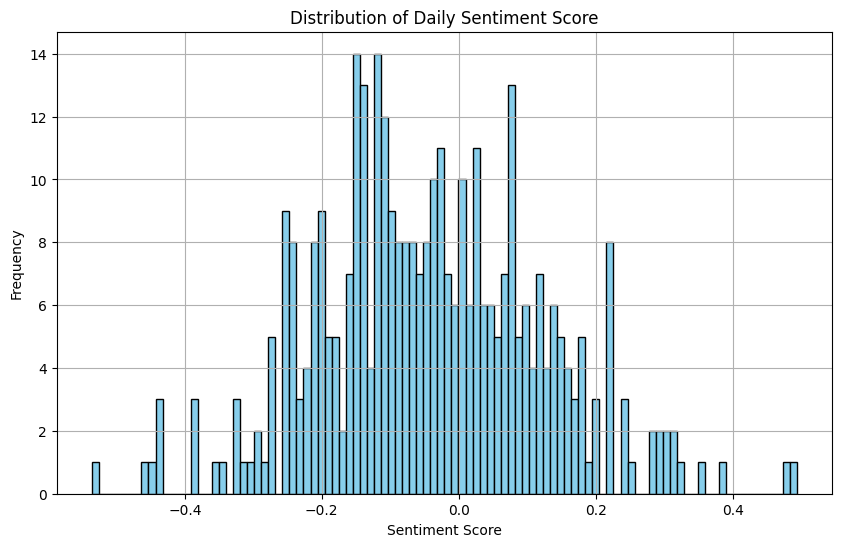

In [ ]:

# Plotting the distribution of 'Sentiment_Score'
plt.figure(figsize=(10, 6))
plt.hist(daily_sentiment['Sentiment_Score'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:

daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], errors='coerce')


print(daily_sentiment['Date'].dtype)

datetime64[ns]


<a id="section-three"></a>
# Get final dataset for training

In [ ]:
all_stocks = pd.read_csv('/content/drive/MyDrive/sentiment/stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

<ipython-input-21-e73bba764937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])


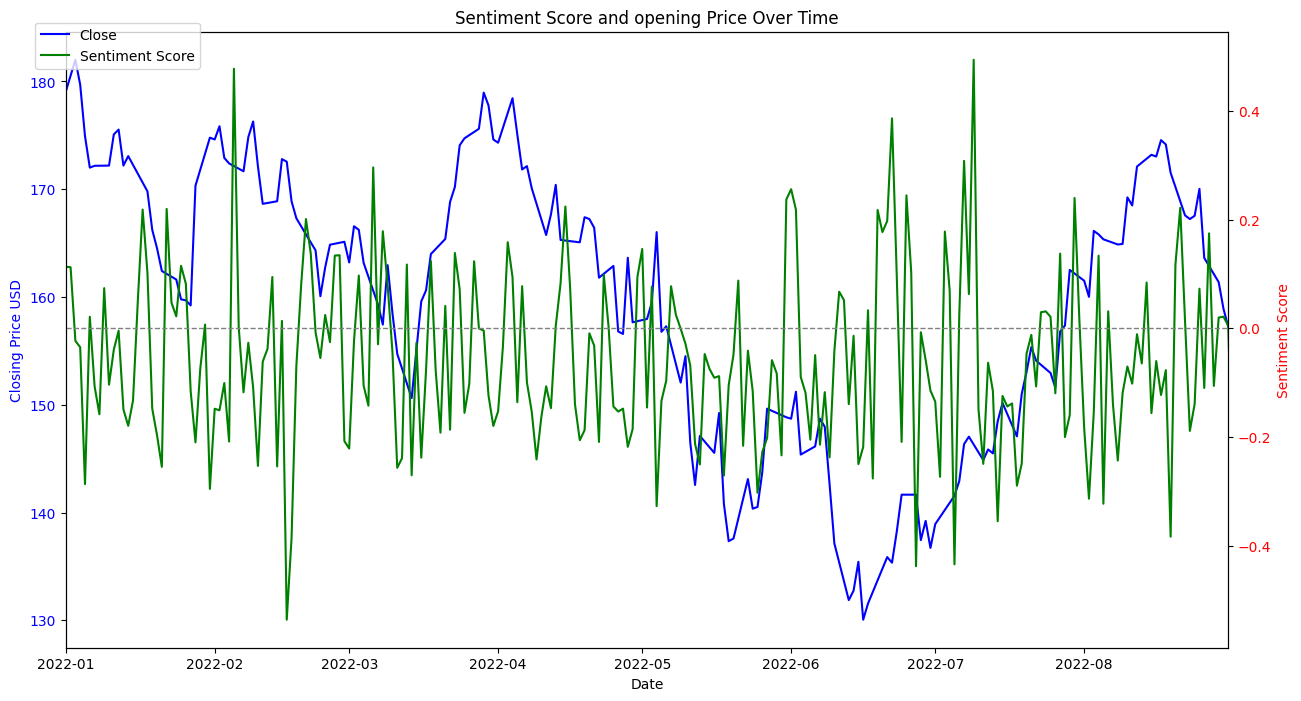

In [ ]:
# Plot the sentiment score and closing price
fig, ax1 = plt.subplots(figsize=(15, 8))
start_date = "2022-01-01"
end_date = "2022-08-31"
# Plot Closing Price on the primary y-axis
ax1.plot(stock_df['Date'], stock_df['Close'], color='b', label='Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price USD', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Create a secondary y-axis for the sentiment score
ax2 = ax1.twinx()
ax2.plot(daily_sentiment['Date'], daily_sentiment['Sentiment_Score'], color='g', label='Sentiment Score')
ax2.set_ylabel('Sentiment Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

# Display the plot
plt.title('Sentiment Score and opening Price Over Time')
plt.show()

In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 1764 to 2015
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        252 non-null    datetime64[ns]
 1   Open        252 non-null    float64       
 2   High        252 non-null    float64       
 3   Low         252 non-null    float64       
 4   Close       252 non-null    float64       
 5   Adj Close   252 non-null    float64       
 6   Volume      252 non-null    int64         
 7   Stock Name  252 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 17.7+ KB


In [ ]:
final_df = pd.merge(stock_df, daily_sentiment, left_on='Date', right_on='Date', how='inner')

In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,-0.390781
1,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL,0.001415
2,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL,0.149919
3,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL,0.222321
4,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL,0.077695


In [ ]:


from google.colab import files
final_df.to_csv('final_df_1_3.csv', encoding='utf-8', index=False)
files.download('final_df_1_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's plot historical price data for the analyzed stock ticker:

In [ ]:
import pandas as pd
from google.colab import files




final_df = pd.read_csv("/content/final_df_1_3.csv")
  # final_df = pd.read_csv(fn)



In [ ]:
# final_df = pd.read_csv('/content/drive/MyDrive/sentiment/final_df.csv')

In [ ]:
data = final_df.copy()

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,-0.390781
1,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL,0.001415
2,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL,0.149919
3,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL,0.222321
4,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL,0.077695


In [ ]:
df = data.copy()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             252 non-null    datetime64[ns]
 1   Open             252 non-null    float64       
 2   High             252 non-null    float64       
 3   Low              252 non-null    float64       
 4   Close            252 non-null    float64       
 5   Adj Close        252 non-null    float64       
 6   Volume           252 non-null    int64         
 7   Stock Name       252 non-null    object        
 8   Sentiment_Score  252 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 17.8+ KB


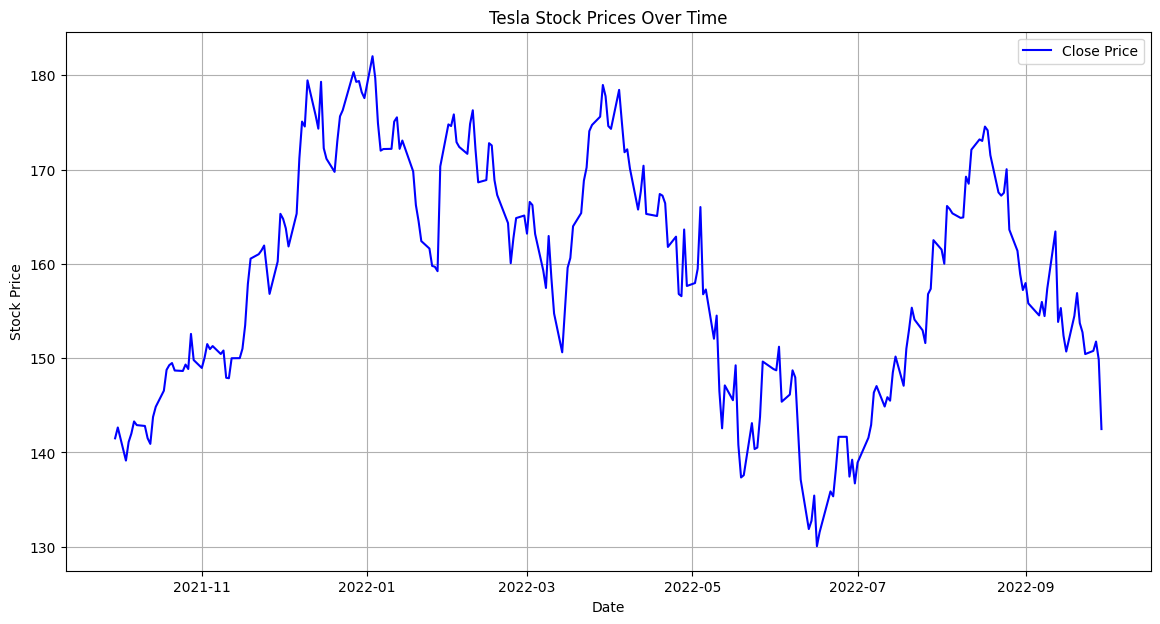

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label="Close Price", color='blue')
plt.title("Tesla Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


###Sentiment Scores over Time
Analyze the sentiment distribution and trends

In [ ]:
import seaborn as sns

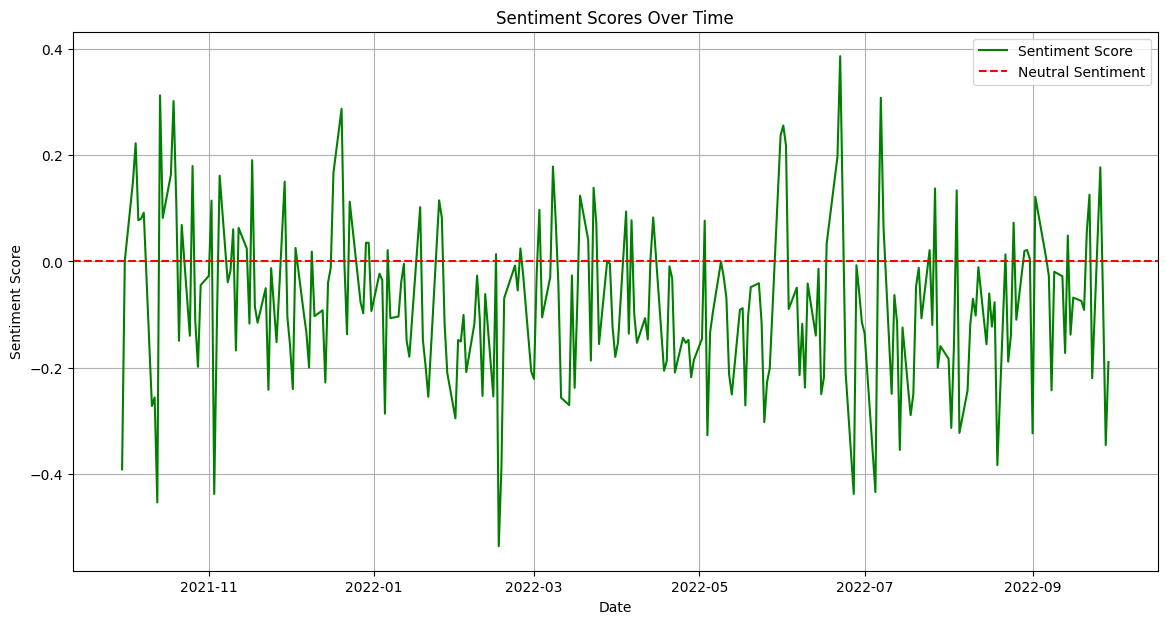

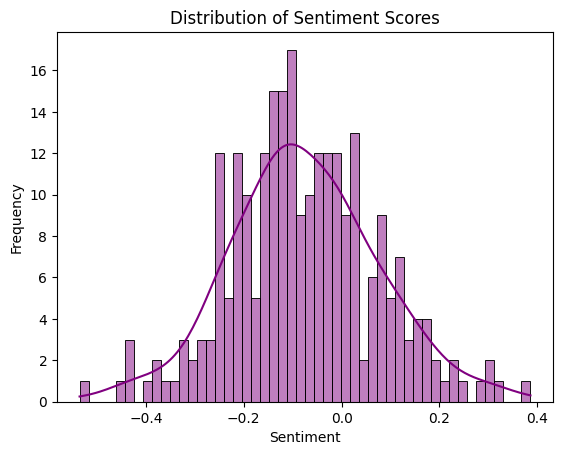

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Sentiment_Score'], label="Sentiment Score", color='green')
plt.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
plt.title("Sentiment Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid()
plt.show()

# Distribution of sentiment scores
sns.histplot(df['Sentiment_Score'], bins=50, kde=True, color='purple')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df.describe

<bound method NDFrame.describe of           Date        Open        High         Low       Close   Adj Close  \
0   2021-09-30  143.660004  144.380005  141.279999  141.500000  140.478485   
1   2021-10-01  141.899994  142.919998  139.110001  142.649994  141.620163   
2   2021-10-04  141.759995  142.210007  138.270004  139.139999  138.135513   
3   2021-10-05  139.490005  142.240005  139.360001  141.110001  140.091278   
4   2021-10-06  139.470001  142.149994  138.369995  142.000000  140.974869   
..         ...         ...         ...         ...         ...         ...   
247 2022-09-23  151.190002  151.470001  148.559998  150.429993  150.180862   
248 2022-09-26  149.660004  153.770004  149.639999  150.770004  150.520309   
249 2022-09-27  152.740005  154.720001  149.949997  151.759995  151.508667   
250 2022-09-28  147.639999  150.639999  144.839996  149.839996  149.591843   
251 2022-09-29  146.100006  146.720001  140.679993  142.479996  142.244034   

        Volume Stock Name  Sentiment_Score  
0     89056700       AAPL        -0.390781  
1     94639600       AAPL         0.001415  
2     98322000       AAPL         0.149919  
3     80861100       AAPL         0.222321  
4     83221100       AAPL         0.077695  
..         ...        ...              ...  
247   96029900       AAPL        -0.219436  
248   93339400       AAPL         0.176954  
249   84442700       AAPL        -0.071245  
250  146691400       AAPL        -0.345105  
251  128138200       AAPL        -0.188948  

[252 rows x 9 columns]>

###Feature Engineering for Strategies
1. Mean Reversion

Logic: Prices revert to their mean over time. We calculate z-scores for price deviations from moving averages.

2. Momentum

Logic: Stocks with positive momentum are likely to continue trending upwards.

3. Sentiment-Driven Strategy

Logic: Positive sentiment is often correlated with price increases.

In [ ]:
df1=df.copy()

In [ ]:
# Calculate moving averages
df1['ma_20'] = df1['Close'].rolling(window=20,min_periods=1).mean()
df1['z_score'] = (df1['Close'] - df1['ma_20']) / df1['Close'].rolling(window=7, min_periods=1).std()




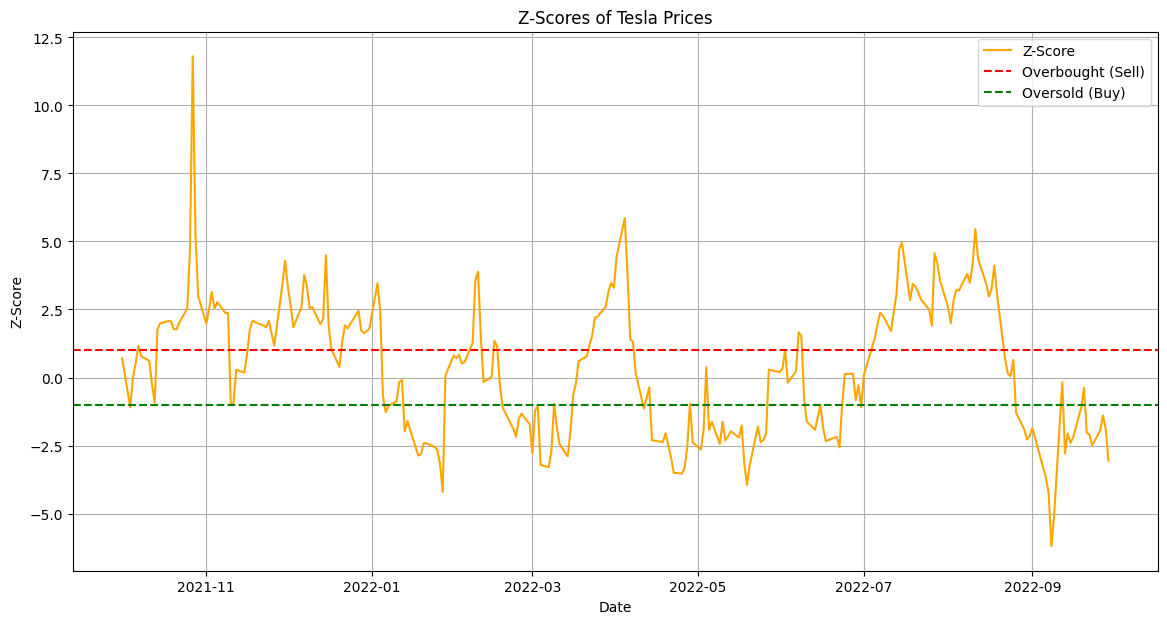

In [ ]:
# Plot z-scores
plt.figure(figsize=(14, 7))
plt.plot(df1['Date'], df1['z_score'], label="Z-Score", color='orange')
plt.axhline(y=1, color='red', linestyle='--', label="Overbought (Sell)")
plt.axhline(y=-1, color='green', linestyle='--', label="Oversold (Buy)")
plt.title("Z-Scores of Tesla Prices")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

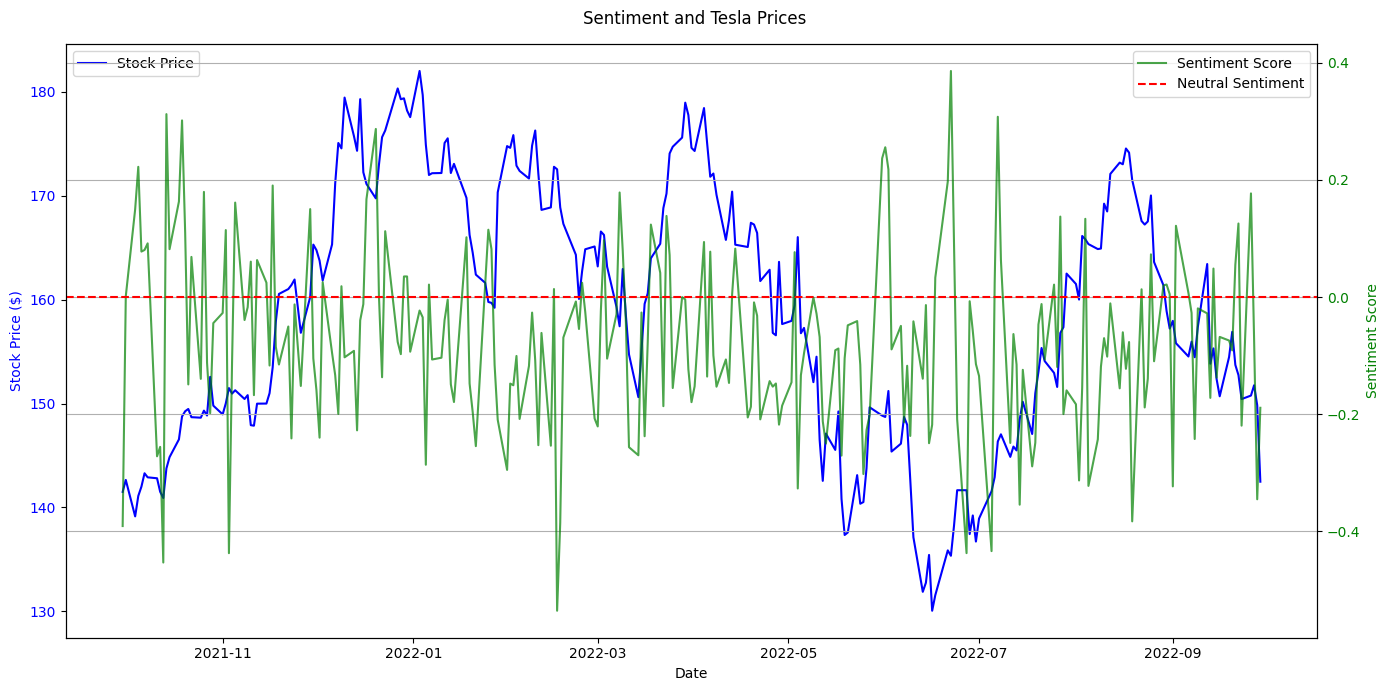

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))


ax1.plot(df1['Date'], df1['Close'], label="Stock Price", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price ($)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(df1['Date'], df1['Sentiment_Score'], label="Sentiment Score", color='green', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
ax2.set_ylabel("Sentiment Score", color='green')
ax2.tick_params(axis='y', labelcolor='green')


fig.suptitle("Sentiment and Tesla Prices")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid()
plt.show()


In [ ]:
            # # Calculate momentum
            # df1['momentum'] = df1['Close'] - df1['Close'].shift(10)

            # # Plot momentum vs sentiment score

            # fig, ax1 = plt.subplots(figsize=(14, 7))
            # ax1.plot(df1['Date'], df1['momentum'], label="Momentum", color='blue')
            # ax1.set_xlabel("Date")
            # ax1.set_ylabel("Momentum", color='blue')
            # ax1.tick_params(axis='y', labelcolor='blue')
            # ax2 = ax1.twinx()
            # ax2.plot(df1['Date'], df1['Sentiment_Score'], label="Sentiment Score", color='green', alpha=0.7)
            # ax2.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
            # ax2.set_ylabel("Sentiment Score", color='green')
            # ax2.tick_params(axis='y', labelcolor='green')
            # fig.suptitle("Momentum vs Sentiment Score")
            # fig.tight_layout()
            # ax1.legend(loc="upper left")
            # ax2.legend(loc="upper right")

            # plt.grid()
            # plt.show()

In [ ]:
# Experiment with multiple lags for future returns
for lag in [1, 3, 7, 14]:
    df1[f'future_returns_lag_{lag}'] = df1['Close'].shift(-lag) / df1['Close'] - 1

# Include additional features
df1['sentiment_volatility'] = df1['Sentiment_Score'].rolling(window=3).std()
df1['lagged_sentiment'] = df1['Sentiment_Score'].shift(1)

# Compute correlation for all features
correlation = df1[['Sentiment_Score', 'sentiment_volatility', 'lagged_sentiment',
                   'future_returns_lag_1', 'future_returns_lag_3', 'future_returns_lag_7', 'future_returns_lag_14']].corr()

# Heatmap
import plotly.express as px
fig = px.imshow(
    correlation,
    text_auto=".2f",
    color_continuous_scale=px.colors.sequential.RdBu,
    labels=dict(color="Correlation"),
    title="Correlation Matrix with Improved Features"
)
fig.show()


**- Log-transforming skewed features is a common technique to reduce the impact of outliers and normalize the data distribution.**

In [ ]:
# Check for skewness before applying log-transformation of scores

from scipy.stats import skew

skew_value = skew(df1['Sentiment_Score'].dropna())
print(f"Skewness: {skew_value}")



Skewness: 0.10503047196180337


In [ ]:
!pip install dash plotly
!pip install jupyter-dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00


### Interactive Dashbaord using Dash

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd



app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Tesla Stock Price and Sentiment Dashboard", style={'text-align': 'center'}),

    dcc.Graph(id="stock-sentiment-plot"),

    html.Div([
        html.Label("Select Date Range:"),
        dcc.DatePickerRange(
            id="date-picker",
            start_date=df1['Date'].min(),
            end_date=df1['Date'].max(),
            display_format="YYYY-MM-DD"
        )
    ], style={'margin': '30px'})
])


@app.callback(
    Output("stock-sentiment-plot", "figure"),
    Input("date-picker", "start_date"),
    Input("date-picker", "end_date")
)
def update_graph(start_date, end_date):
    filtered_df = df1[(df1['Date'] >= start_date) & (df1['Date'] <= end_date)]


    fig = go.Figure()

    # Stock price
    fig.add_trace(go.Scatter(
        x=filtered_df['Date'], y=filtered_df['Close'],
        mode='lines', name='Stock Price',
        line=dict(color='blue')
    ))

    # Sentiment score
    fig.add_trace(go.Scatter(
        x=filtered_df['Date'], y=filtered_df['Sentiment_Score'],
        mode='lines', name='Sentiment Score',
        line=dict(color='green'), opacity=0.7, yaxis='y2'
    ))


    fig.update_layout(
        title="Stock Price and Sentiment Over Time",
        xaxis_title="Date",
        yaxis=dict(title="Stock Price ($)", titlefont=dict(color='blue'), tickfont=dict(color='blue')),
        yaxis2=dict(title="Sentiment Score", overlaying="y", side="right", titlefont=dict(color='green'), tickfont=dict(color='green')),
        legend=dict(x=0, y=1.2, orientation="h"),
        margin=dict(l=40, r=40, t=40, b=40)
    )
    return fig


app.run_server(mode='inline')


<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def preprocess_data_zscore(df, feature_columns, target_column, sequence_length, exclude_columns=[]):
    """
    Preprocess the data using z-score normalization.
    """
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    columns_to_scale = [col for col in feature_columns if col not in exclude_columns]
    df[columns_to_scale] = feature_scaler.fit_transform(df[columns_to_scale])
    df[target_column] = target_scaler.fit_transform(df[[target_column]])


    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i+sequence_length].values)
        y.append(df[target_column].iloc[i+sequence_length])

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y, feature_scaler, target_scaler

# Drop rows with NaN values
df1 = df1.dropna()


sequence_length = 30
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'ma_20', 'z_score', 'future_returns_lag_1', 'future_returns_lag_3', 'sentiment_volatility']
target_column = 'future_returns_lag_7'

exclude_columns = ['sentiment_volatility', 'Sentiment_Score']

# Prepare data
X, y, scaler, target_scaler = preprocess_data_zscore(df1, feature_columns, target_column, sequence_length, exclude_columns)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


<ipython-input-47-57dc1a2fb96a>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-47-57dc1a2fb96a>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    out, _ = self.lstm(x)  # LSTM output
    out = self.fc(out[:, -1, :])  # Output of the last time step
    return out


input_dim = len(feature_columns)  # Number of input features
hidden_dim = 64
output_dim = 1  # {sentiment 7 day}: target variable
num_layers = 2
dropout = 0.2

# Define Training Process
# def train_model(model, train_loader, criterion, optimizer, num_epochs):
#   for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for X_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch.unsqueeze(1))
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")

def train_model(model, train_loader, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Check for NaNs
        if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
            print("NaNs detected in data!")
            continue

        y_pred = model(X_batch)


        if torch.isnan(y_pred).any():
            print("NaNs detected in predictions!")
            continue

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")



# Initialize Model, Loss, Optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Model
num_epochs = 50
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate Model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred = target_scaler.inverse_transform(y_pred.numpy().reshape(-1, 1)).flatten()
    y_actual = target_scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Calculate Metrics
rmse = np.sqrt(np.mean((y_pred - y_actual) ** 2))
directional_accuracy = np.mean((y_pred > 0) == (y_actual > 0))

print(f"Test RMSE: {rmse:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

# Trading Strategy
# def generate_signals(predictions, threshold=0.02):
#     signals = []
#     for pred in predictions:
#         if pred > threshold:
#             signals.append("Buy")
#         elif pred < -threshold:
#             signals.append("Sell")
#         else:
#             signals.append("Hold")
#     return signals

# signals = generate_signals(y_pred)
# print("Generated Signals:", signals[:10])


Epoch 1/50, Loss: 1.1448
Epoch 2/50, Loss: 1.0789
Epoch 3/50, Loss: 1.0614
Epoch 4/50, Loss: 1.0813
Epoch 5/50, Loss: 1.0196
Epoch 6/50, Loss: 1.0851
Epoch 7/50, Loss: 0.9431
Epoch 8/50, Loss: 0.9555
Epoch 9/50, Loss: 0.9931
Epoch 10/50, Loss: 0.9468
Epoch 11/50, Loss: 0.9816
Epoch 12/50, Loss: 0.9430
Epoch 13/50, Loss: 0.9274
Epoch 14/50, Loss: 0.8813
Epoch 15/50, Loss: 0.8825
Epoch 16/50, Loss: 0.8891
Epoch 17/50, Loss: 0.8089
Epoch 18/50, Loss: 0.8490
Epoch 19/50, Loss: 0.7952
Epoch 20/50, Loss: 0.7613
Epoch 21/50, Loss: 0.7161
Epoch 22/50, Loss: 0.7043
Epoch 23/50, Loss: 0.7100
Epoch 24/50, Loss: 0.6807
Epoch 25/50, Loss: 0.6721
Epoch 26/50, Loss: 0.6702
Epoch 27/50, Loss: 0.6423
Epoch 28/50, Loss: 0.6389
Epoch 29/50, Loss: 0.5591
Epoch 30/50, Loss: 0.5713
Epoch 31/50, Loss: 0.5331
Epoch 32/50, Loss: 0.5670
Epoch 33/50, Loss: 0.5049
Epoch 34/50, Loss: 0.4598
Epoch 35/50, Loss: 0.4555
Epoch 36/50, Loss: 0.4168
Epoch 37/50, Loss: 0.3840
Epoch 38/50, Loss: 0.3646
Epoch 39/50, Loss: 0.

### Trend following strategy

In [ ]:
# # Parameters for the strategy
# threshold = 0.02  # 2% price change threshold
# initial_balance = 10000  # Starting capital
# position = 0  # Current position (0 = no position, 1 = holding stock)
# balance = initial_balance  # Remaining balance
# portfolio = []  # Track portfolio value

# # Simulated Trading
# for i in range(len(y_pred) - 1):
#     predicted_change = (y_pred[i+1] - y_pred[i]) / y_pred[i]
#     actual_change = (y_actual[i+1] - y_actual[i]) / y_actual[i]
#     current_price = y_actual[i]

#     if position == 0:  # No position
#         if predicted_change > threshold:  # Buy signal
#             position = balance / current_price  # Buy as many shares as possible
#             balance = 0  # Deduct from cash
#             print(f"Buying at {current_price:.2f}, Position: {position:.2f} shares")
#         elif predicted_change < -threshold:  # Short-sell signal (if allowed)
#             position = -balance / current_price
#             balance = 0
#             print(f"Short-selling at {current_price:.2f}, Position: {position:.2f} shares")

#     elif position > 0:  # Holding long position
#         if predicted_change < -threshold:  # Sell signal
#             balance = position * current_price  # Sell all shares
#             position = 0
#             print(f"Selling at {current_price:.2f}, Balance: {balance:.2f}")

#     elif position < 0:  # Holding short position
#         if predicted_change > threshold:  # Cover short position
#             balance = -position * current_price
#             position = 0
#             print(f"Covering short at {current_price:.2f}, Balance: {balance:.2f}")

#     # Track portfolio value
#     portfolio.append(balance + (position * current_price if position != 0 else 0))

# # Final Portfolio Value
# final_balance = balance + (position * y_actual[-1] if position != 0 else 0)
# print(f"Final Portfolio Value: {final_balance:.2f}")

# # Plotting the portfolio value over time
# plt.figure(figsize=(10, 6))
# plt.plot(portfolio, label='Portfolio Value', color='blue')
# plt.xlabel('Time Step')
# plt.ylabel('Portfolio Value')
# plt.title('Trading Strategy Portfolio Performance Over Time')
# plt.legend()
# plt.show()


### Stop-Loss / Take-Profit Strategy
1.   Buy (or Short) based on the model's prediction.
2.   Set a Stop-Loss level, typically a percentage below the entry price for a long position and above the entry price for a short position.
3. Set a Take-Profit level, typically a percentage above the entry price for a long position and below the entry price for a short position.
4. Exit the position automatically when either the Stop-Loss or Take-Profit level is hit.
5. Track the portfolio value over time.


Short-selling at 0.06, Position: -169174.62 shares, Stop-Loss: 0.06, Take-Profit: 0.06
Covering short at 0.03 (Take-Profit), Balance: 5104.75
Buying at 0.01, Position: 536066.72 shares, Stop-Loss: 0.01, Take-Profit: 0.01
Selling at 0.07 (Take-Profit), Balance: 35429.12
Short-selling at 0.04, Position: -842487.04 shares, Stop-Loss: 0.04, Take-Profit: 0.04
Covering short at 0.06 (Stop-Loss), Balance: 52132.47
Buying at 0.04, Position: 1356941.77 shares, Stop-Loss: 0.04, Take-Profit: 0.04
Selling at 0.09 (Take-Profit), Balance: 116930.40
Short-selling at 0.09, Position: -1247477.75 shares, Stop-Loss: 0.10, Take-Profit: 0.09
Covering short at 0.05 (Take-Profit), Balance: 68106.55
Short-selling at 0.05, Position: -1425077.33 shares, Stop-Loss: 0.05, Take-Profit: 0.04
Covering short at 0.01 (Take-Profit), Balance: 21133.73
Buying at 0.05, Position: 441565.72 shares, Stop-Loss: 0.05, Take-Profit: 0.05
Selling at 0.05 (Take-Profit), Balance: 23401.55
Short-selling at 0.04, Position: -651205.89

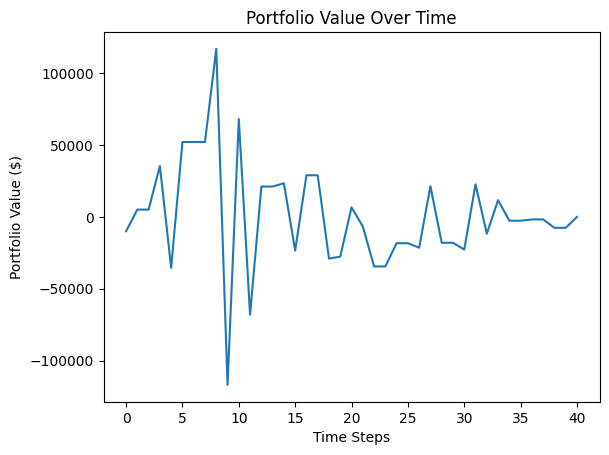

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the strategy
threshold = 0.02
initial_balance = 10000  # Starting capital
stop_loss_pct = 0.03  # 3% stop-loss
take_profit_pct = 0.06  # 6% take-profit
position = 0  # Current position (0 = no position, 1 = holding stock, -1 = short position)
balance = initial_balance
portfolio = []  # Track portfolio value


for i in range(len(y_pred) - 1):
    predicted_change = (y_pred[i+1] - y_pred[i]) / y_pred[i]
    actual_change = (y_actual[i+1] - y_actual[i]) / y_actual[i]
    current_price = y_actual[i]


    if position == 0:
        if predicted_change > threshold:  # Buy signal
            entry_price = current_price
            position = balance / entry_price  # Buy as many shares as possible
            balance = 0  # Deduct from cash
            stop_loss_price = entry_price * (1 - stop_loss_pct)  # Set stop-loss
            take_profit_price = entry_price * (1 + take_profit_pct)  # Set take-profit
            print(f"Buying at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")
        elif predicted_change < -threshold:  # Short-sell signal
            entry_price = current_price
            position = -balance / entry_price  # Short-sell the stock
            balance = 0
            stop_loss_price = entry_price * (1 + stop_loss_pct)  # Set stop-loss for short
            take_profit_price = entry_price * (1 - take_profit_pct)  # Set take-profit for short
            print(f"Short-selling at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")


    elif position > 0:
        if current_price <= stop_loss_price:  # Stop-loss hit
            balance = position * current_price  # Sell all shares at stop-loss price
            position = 0
            print(f"Selling at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price >= take_profit_price:  # Take-profit hit
            balance = position * current_price  # Sell all shares at take-profit price
            position = 0
            print(f"Selling at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")


    elif position < 0:
        if current_price >= stop_loss_price:  # Stop-loss hit for short
            balance = -position * current_price  # Cover short at stop-loss price
            position = 0
            print(f"Covering short at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price <= take_profit_price:  # Take-profit hit for short
            balance = -position * current_price  # Cover short at take-profit price
            position = 0
            print(f"Covering short at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")

    # Track portfolio value
    portfolio.append(balance + (position * current_price if position != 0 else 0))


final_balance = balance + (position * y_actual[-1] if position != 0 else 0)
print(f"Final Portfolio Value: {final_balance:.2f}")


plt.plot(portfolio)
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value ($)")
plt.show()


In [ ]:
Profits = final_balance - initial_balance
print(f"Profits: {Profits:.2f}")

Profits: -9970.92




> ***Change the code down here to something original. brainstorm it.***



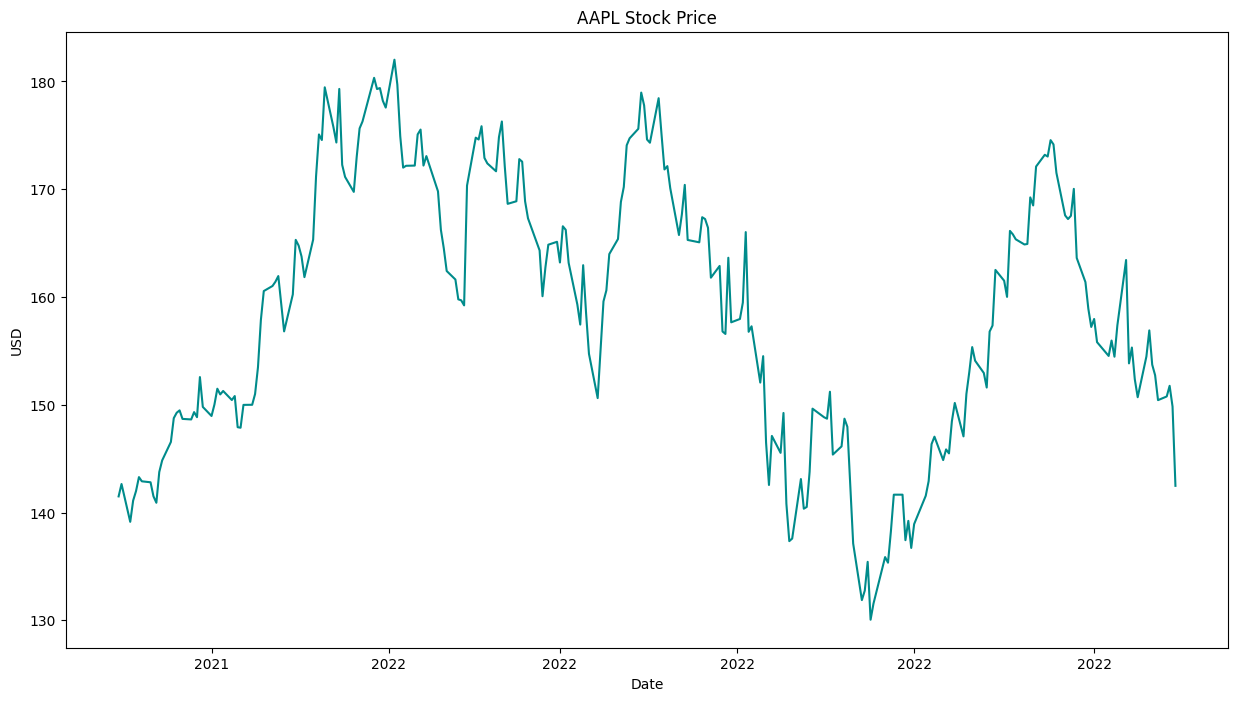

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(stock_df['Date'], stock_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [ ]:
(all_tweets["Stock Name"].unique())

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)